In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, GlobalAveragePooling2D, Input, \
    BatchNormalization, ReLU, Add, Activation, multiply, Reshape, Lambda, Dropout, Concatenate, DepthwiseConv2D
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        memory_limit = 7680  
        config = tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(gpu, [config])
    except RuntimeError as e:
        print(e)

In [3]:
# 数据增强配置
train_datagen = ImageDataGenerator(rescale=1.0 / 255)  
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
DATA_PATH = 'RGB_augmented_300_224'
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)

train_generator = train_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\train',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)


validation_generator = validation_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)


test_generator = test_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\test',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

Found 900 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [4]:
weights = [2.25, 2.25, 1]  


def focal_loss_function(weights, gamma=2, eps=1e-7):
    weights = tf.constant(weights, dtype=tf.float32)

    def focal_loss(y_true, y_pred):
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], tf.shape(y_pred)[1], -1))  
        target = tf.reshape(y_true, tf.shape(y_pred))  

        ce = -1 * tf.math.log(y_pred + eps) * target
        floss = tf.pow((1 - y_pred), gamma) * ce
        floss = floss * weights
        floss = tf.reduce_sum(floss, axis=1)
        return tf.reduce_mean(floss)

    return focal_loss


custom_focal_loss = focal_loss_function(weights)


def weighted_accuracy(weights):
 
    max_weight = max(weights)
    normalized_weights = [w / max_weight for w in weights]

    def accuracy(y_true, y_pred):
     
        true_class = K.argmax(y_true, axis=-1)
        pred_class = K.argmax(y_pred, axis=-1)
        accuracy = K.cast(K.equal(true_class, pred_class), 'float32')

        class_weights = K.gather(K.constant(normalized_weights), true_class)
        weighted_accuracy = K.sum(accuracy * class_weights) / K.sum(class_weights)

        return weighted_accuracy

    return accuracy


custom_acc = weighted_accuracy(weights)

In [5]:
def SEBlock(input_tensor, reduction_ratio=16):
    # Squeeze
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, -1))(se)
    # Excitation
    se = Dense(input_tensor.shape[-1] // reduction_ratio, activation='relu')(se)
    se = Dense(input_tensor.shape[-1], activation='sigmoid')(se)
    return multiply([input_tensor, se])

In [6]:
def InceptionModule(input_tensor, c1, c2, c3, c4, use_se=False):
    # Path 1
    path1_conv1x1 = Conv2D(c1, 1, activation='relu')(input_tensor)
    # Path 2
    path2_conv1x1 = Conv2D(c2[0], 1, activation='relu')(input_tensor)
    path2_conv3x3 = Conv2D(c2[1], 3, padding='same', activation='relu')(path2_conv1x1)
    
    # Path 3
    path3_conv1x1 = Conv2D(c3[0], 1, activation='relu')(input_tensor)
    path3_conv5x5 = Conv2D(c3[1], 5, padding='same', activation='relu')(path3_conv1x1)
    
    # Path 4
    path4_maxpool = MaxPooling2D(3, 1, padding='same')(input_tensor)
    path4_conv1x1 = Conv2D(c4, 1, activation='relu')(path4_maxpool)
    
    x = Concatenate()([path1_conv1x1, path2_conv3x3, path3_conv5x5, path4_conv1x1])

    # SE Block
    if use_se:
        x = SEBlock(x)

    return x

# InceptionModule 
def InceptionModuleWithResidual(input_tensor, c1, c2, c3, c4, use_se=False):
    x = InceptionModule(input_tensor, c1, c2, c3, c4, use_se)

    if input_tensor.shape[-1] != x.shape[-1]:
        input_tensor = Conv2D(x.shape[-1], 1, padding='same', activation='relu')(input_tensor)

    x = Add()([input_tensor, x])
    return x


def Inception_with_residual():
    input_tensor = Input(shape=(224, 224, 3))

    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = InceptionModuleWithResidual(x, 64, (48, 64), (8, 16), 16, use_se=True)
    x = InceptionModuleWithResidual(x, 96, (64, 96), (16, 32), 32, use_se=True)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = InceptionModuleWithResidual(x, 128, (64, 96), (16, 32), 32, use_se=True)
    x = InceptionModuleWithResidual(x, 160, (80, 112), (16, 48), 48, use_se=True)
    
    x = InceptionModuleWithResidual(x, 192, (96, 128), (32, 64), 64, use_se=True)
    x = InceptionModuleWithResidual(x, 224, (112, 144), (32, 64), 64, use_se=True)
    
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = InceptionModuleWithResidual(x, 256, (128, 160), (48, 96), 96, use_se=True)
    x = InceptionModuleWithResidual(x, 288, (144, 192), (48, 96), 96, use_se=True)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output_tensor = Dense(3, activation='softmax')(x)

    return Model(inputs=input_tensor, outputs=output_tensor)

In [7]:
MODEL = Inception_with_residual()
MODEL.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_focal_loss, metrics=custom_acc)
# combined_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
MODEL.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [8]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     verbose=1,
#     patience=10,
#     mode='min',
#     restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r"D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_inception\IAR.h5",
    monitor='val_accuracy',       
    verbose=1,                    
    save_best_only=True,        
    mode='max'                    
)

csv_logger = tf.keras.callbacks.CSVLogger(r"D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_inception\IAR.csv", separator=",", append=False)
history = MODEL.fit(
    train_generator,
    epochs=150, 
    validation_data=validation_generator,
    callbacks=[csv_logger, checkpoint]  
)

Epoch 1/150
57/57 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.4354
Epoch 00001: val_accuracy improved from -inf to 0.49120, saving model to D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_inception\IAR.h5
57/57 [==============================] - 11s 94ms/step - loss: 0.8804 - accuracy: 0.4354 - val_loss: 0.8760 - val_accuracy: 0.4912


C:\Users\23076\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/150
57/57 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.5781
Epoch 00002: val_accuracy did not improve from 0.49120
57/57 [==============================] - 3s 48ms/step - loss: 0.6327 - accuracy: 0.5781 - val_loss: 0.6397 - val_accuracy: 0.4776
Epoch 3/150
56/57 [============================>.] - ETA: 0s - loss: 0.4885 - accuracy: 0.6272
Epoch 00003: val_accuracy improved from 0.49120 to 0.56421, saving model to D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_inception\IAR.h5
57/57 [==============================] - 3s 52ms/step - loss: 0.4876 - accuracy: 0.6308 - val_loss: 0.6289 - val_accuracy: 0.5642
Epoch 4/150
56/57 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.6600
Epoch 00004: val_accuracy did not improve from 0.56421
57/57 [==============================] - 3s 49ms/step - loss: 0.3880 - accuracy: 0.6592 - val_loss: 0.5533 - val_accuracy: 0.4676
Epoch 5/150
57/57 [==============================] - ETA: 0

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, precision_score, f1_score, \
    precision_recall_curve


custom_objects = {'focal_loss': custom_focal_loss, 'accuracy': custom_acc}
MODEL_BEST = load_model(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_inception\IAR.h5',custom_objects=custom_objects)

def plot_from_csv(csv_file_path, test_loss, test_accuracy):
    data = pd.read_csv(csv_file_path)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(data['loss'], label='Train Loss')
    plt.plot(data['val_loss'], label='Validation Loss')
    plt.axhline(y=test_loss, label='Test Loss', color='green', linestyle='--')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(0, 1.02)

    plt.subplot(1, 2, 2)
    plt.plot(data['accuracy'], label='Train Accuracy')
    plt.plot(data['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_accuracy, label='Test Accuracy', color='green', linestyle='--')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.ylim(0, 1.02)
    plt.show()
    
# evaluation_metrics = MODEL_BEST.evaluate(test_generator)
# test_loss = evaluation_metrics[0]
# test_accuracy = evaluation_metrics[1]
# print('Test Loss:', test_loss)
# print('Test Accuracy:', test_accuracy)

In [10]:
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.axhline(y=test_loss, label='Test Loss', color='green', linestyle='--')  # 添加测试损失
# plt.title('Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# 
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.axhline(y=test_accuracy, label='Test Accuracy', color='green', linestyle='--')  # 添加测试准确率
# plt.title('Accuracy Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [11]:
# MODEL.save(r'D:\Download\MV_Coursework\Coursework\Code\figure\inception_net\inception_with_attention.h5')

In [12]:
# from tensorflow.python.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras.metrics import CategoricalCrossentropy
test_images = []
test_labels = []

for i in range(len(test_generator)):
    x, y = test_generator[i]
    test_images.append(x)
    test_labels.append(y)

test_data = np.concatenate(test_images)
y_true = np.concatenate(test_labels)
y_probs = MODEL_BEST.predict(test_data)

loss_function = CategoricalCrossentropy()
accuracy_fuction = tf.keras.metrics.CategoricalAccuracy()
loss = loss_function(y_true, y_probs)
accuracy = accuracy_fuction(y_true, y_probs)

accuracy_percent = accuracy.numpy() * 100
accuracy_percent = "{:.2f}%".format(accuracy_percent)
# loss = "{:.4f}".format(loss.numpy())
print("Accuracy:", accuracy_percent)
print("Loss:", loss.numpy())

Accuracy: 95.24%
Loss: 0.10197134


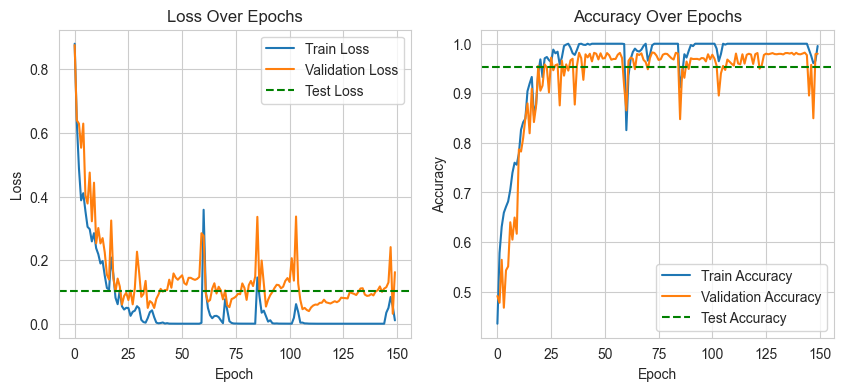

In [13]:
plot_from_csv(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_inception\IAR.csv', loss.numpy(), accuracy)

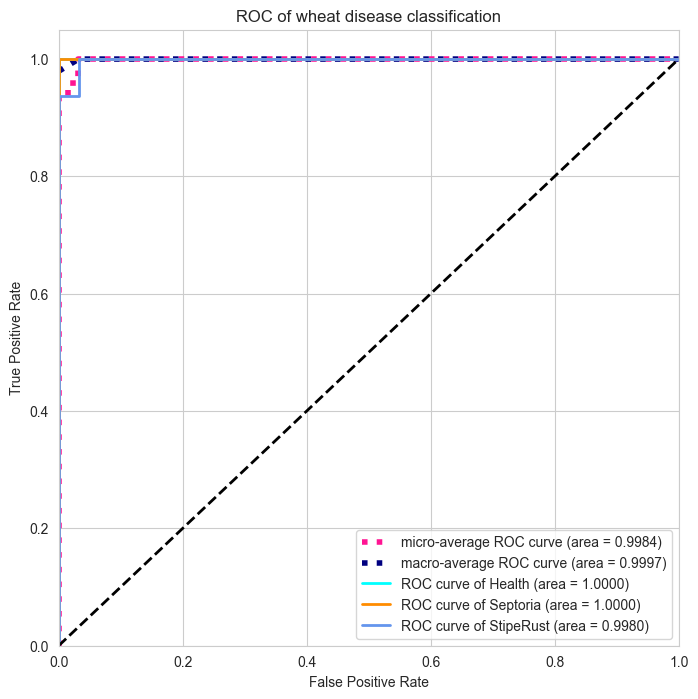

In [18]:
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"], tpr["macro"], _ = all_fpr, mean_tpr, np.zeros_like(all_fpr)
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 8))


plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
class_names = ["Health", "Septoria", "StipeRust"]  # 请替换成实际的类别名称

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.4f})'
                   ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of wheat disease classification')
plt.legend(loc="lower right")
plt.show()

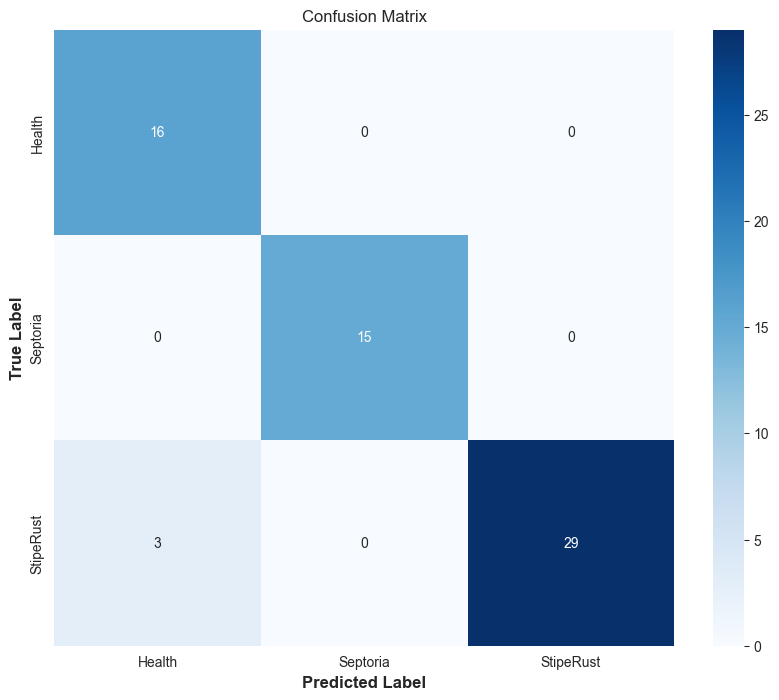

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ["Health", "Septoria", "StipeRust"] 

y_pred = np.argmax(y_probs, axis=1)
y_true_classes = np.argmax(y_true, axis=1)  
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

recall = recall_score(y_true_classes, y_pred, average='weighted')
precision = precision_score(y_true_classes, y_pred, average='weighted')
f1 = f1_score(y_true_classes, y_pred, average='weighted')

recall = recall * 100
recall = "{:.2f}%".format(recall)
precision = precision * 100
precision = "{:.2f}%".format(precision)
f1 = f1 * 100
f1 = "{:.2f}%".format(f1)

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Recall: 95.24%
Precision: 95.99%
F1 Score: 95.33%


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_classes, y_pred)
n_classes = cm.shape[0]

specificity = np.zeros(n_classes)
sensitivity = np.zeros(n_classes)
for i in range(n_classes):
    TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    FP = cm[:, i].sum() - cm[i, i]
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0

weights = cm.sum(axis=1) / cm.sum()

weighted_specificity = np.average(specificity, weights=weights)
weighted_sensitivity = np.average(sensitivity, weights=weights)

weighted_specificity = weighted_specificity * 100
weighted_specificity = "{:.2f}%".format(weighted_specificity)
weighted_sensitivity = weighted_sensitivity * 100
weighted_sensitivity = "{:.2f}%".format(weighted_sensitivity)

print(f"Weighted Specificity: {weighted_specificity}")
print(f"Weighted Sensitivity: {weighted_sensitivity}")


Weighted Specificity: 98.38%
Weighted Sensitivity: 95.24%


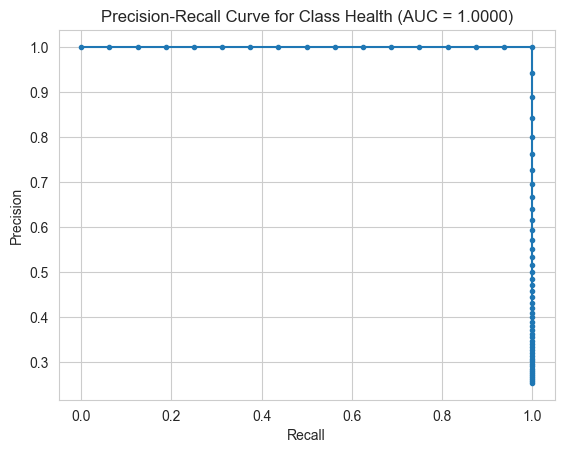

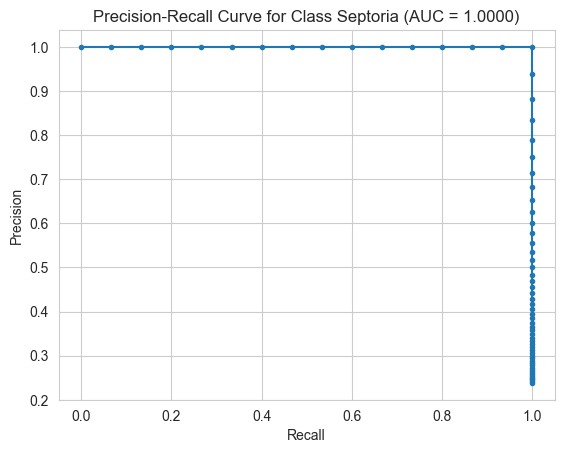

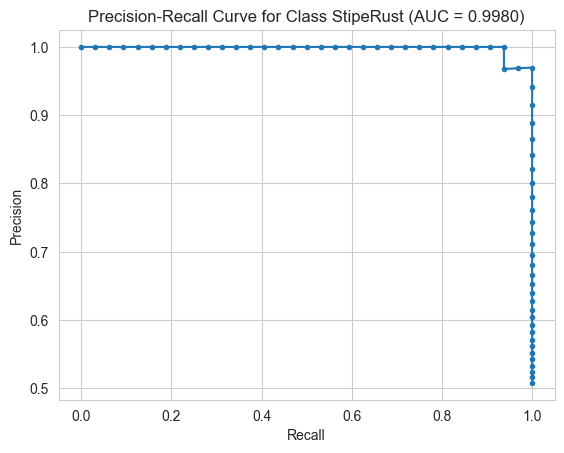

In [22]:
from sklearn.metrics import auc

for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
    auc_score = auc(recall, precision)

    plt.figure()
    
    plt.plot(recall, precision, marker='.')
    
    class_names = ["Health", "Septoria", "StipeRust"]
    plt.title('Precision-Recall Curve for Class {} (AUC = {:.4f})'.format(class_names[i], auc_score))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [23]:
def mcc_score(y_true, y_pred, class_label):
    """
    Calculate Matthew Correlation Coefficient for a specific class.
    """
    cm = confusion_matrix(y_true, y_pred)

    tp = cm[class_label, class_label]
    tn = np.sum(cm) - np.sum(cm[class_label, :]) - np.sum(cm[:, class_label]) + tp
    fp = np.sum(cm[:, class_label]) - tp
    fn = np.sum(cm[class_label, :]) - tp

    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    # To avoid division by zero
    if denominator == 0:
        return 0

    return numerator / denominator

y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = y_pred

mcc_scores = [mcc_score(y_true_classes, y_pred_classes, i) for i in range(n_classes)]

average_mcc = np.mean(mcc_scores)
average_mcc_percentage = average_mcc * 100
formatted_percentage = "{:.2f}%".format(average_mcc_percentage)
print(f"Average MCC: {formatted_percentage}")

Average MCC: 93.23%


In [ ]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()
#
del MODEL